# Documentation 3.2. Just train the model using dementia data

We first try to use the data we crawled from the Internet to build the CNN model to classify whether a person has dementia.

For training and test data, there are two classes: 'dementia' and 'normal'.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install keras-tuner -q

     |████████████████████████████████| 135 kB 31.5 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers 
from keras.utils.vis_utils import plot_model
from tensorflow import keras
from PIL import Image

## Part 1: Load the data

In [4]:
# we divided two dataset into train, validation and test
# use train and validation to build the model, select images from test dataset to do the test
path_train = '/content/drive/My Drive/STAT8021/project/dementia_data/train'
path_val = '/content/drive/My Drive/STAT8021/project/dementia_data/val'

In [5]:
image_size = (180, 180)
batch_size = 32

# Generate training dataset and test dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_train,
    # validation_split=0.2,
    # subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_val,
    # validation_split=0.2,
    # subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 689 files belonging to 2 classes.
Found 294 files belonging to 2 classes.


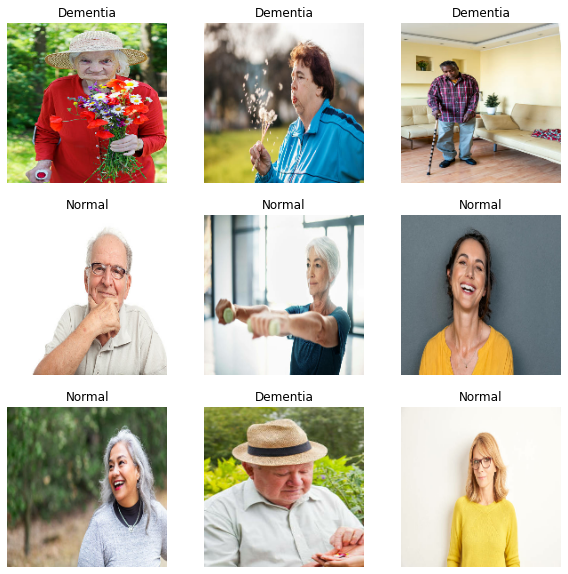

In [6]:
# Visualize the data

image_label = ['Dementia', 'Normal']
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(image_label[int(labels[i])])
        plt.axis("off")

In [7]:
'''
  In our project, we don't have a large image dataset, it's a good practice to 
  artificially introduce sample diversity by applying random yet realistic 
  transformations to the training images, such as random horizontal flipping or 
  small random rotations. This helps expose the model to different aspects of 
  the training data while slowing down overfitting.
'''
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Part 2: Build the model

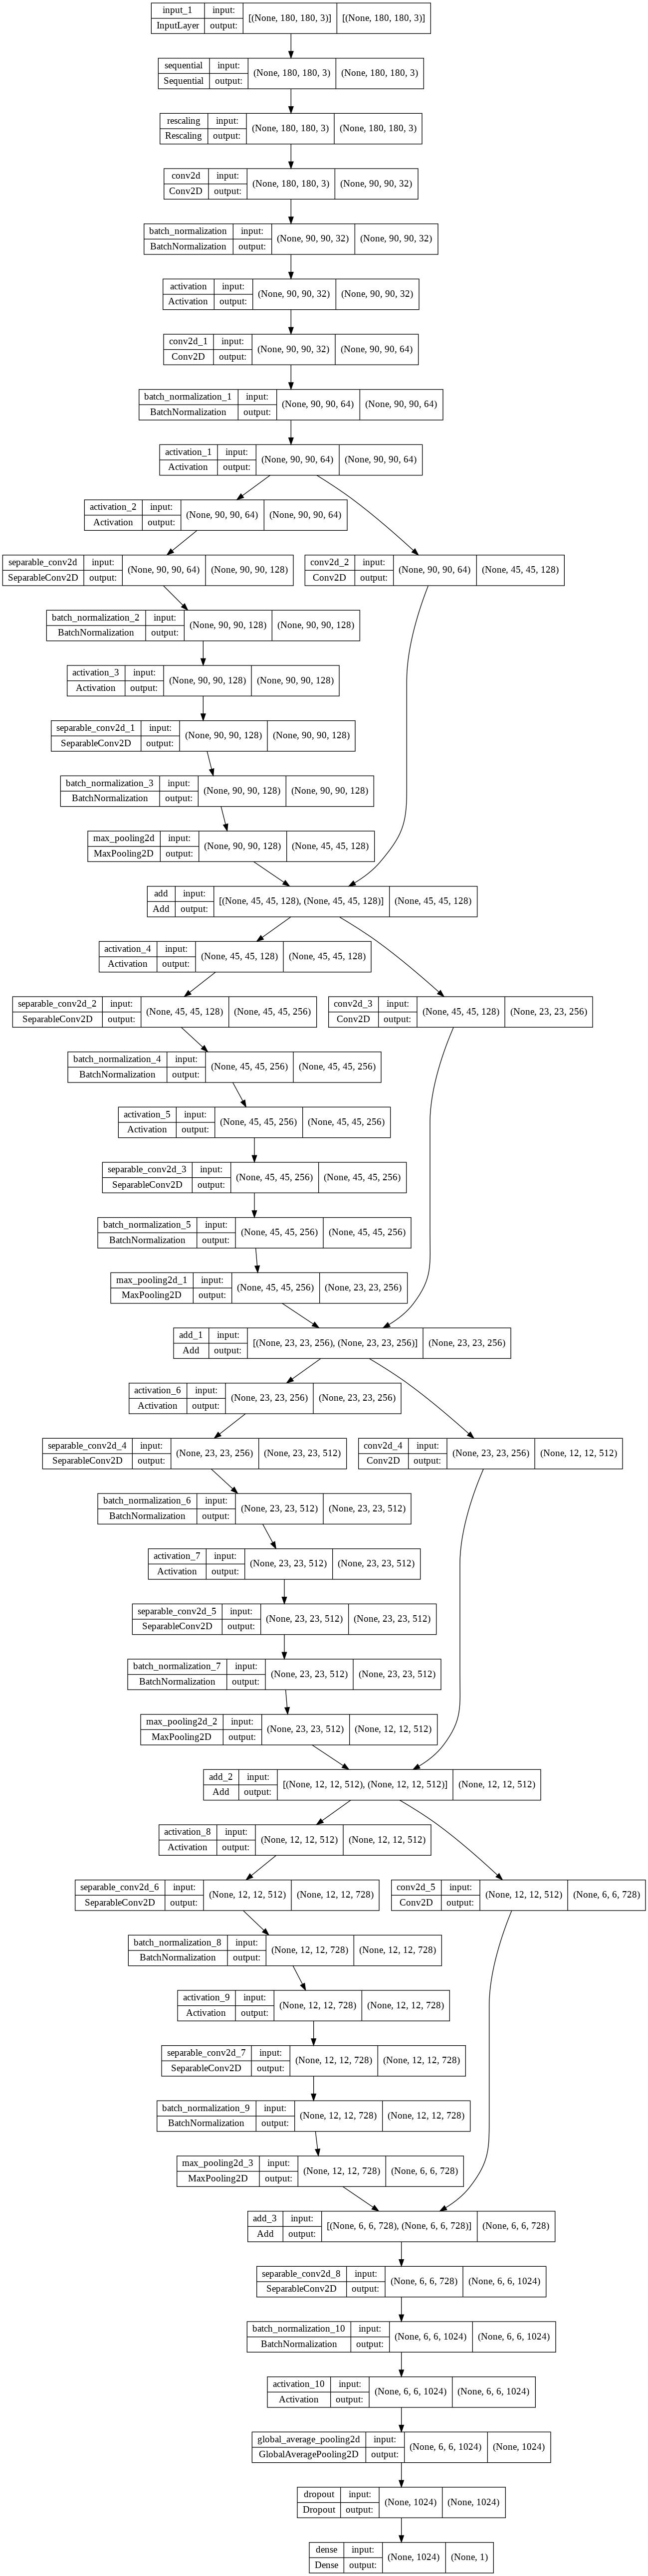

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, to_file='/content/drive/My Drive/STAT8021/project/direct_CNN_model.jpg', show_shapes=True)

In [10]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
hist = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
22/22 [==============================] - 183s 8s/step - loss: 0.7874 - accuracy: 0.5385 - val_loss: 0.6930 - val_accuracy: 0.5034
Epoch 2/50
22/22 [==============================] - 8s 320ms/step - loss: 0.6776 - accuracy: 0.6183 - val_loss: 0.6929 - val_accuracy: 0.5068
Epoch 3/50
22/22 [==============================] - 8s 326ms/step - loss: 0.6293 - accuracy: 0.6589 - val_loss: 0.7017 - val_accuracy: 0.5068
Epoch 4/50
22/22 [==============================] - 8s 326ms/step - loss: 0.5864 - accuracy: 0.7112 - val_loss: 0.7393 - val_accuracy: 0.5068
Epoch 5/50
22/22 [==============================] - 8s 328ms/step - loss: 0.5931 - accuracy: 0.7097 - val_loss: 0.7711 - val_accuracy: 0.5068
Epoch 6/50
22/22 [==============================] - 8s 328ms/step - loss: 0.5468 - accuracy: 0.7199 - val_loss: 0.7944 - val_accuracy: 0.5068
Epoch 7/50
22/22 [==============================] - 8s 327ms/step - loss: 0.5155 - accuracy: 0.7504 - val_loss: 0.8599 - val_accuracy: 0.5068
Epoch 8

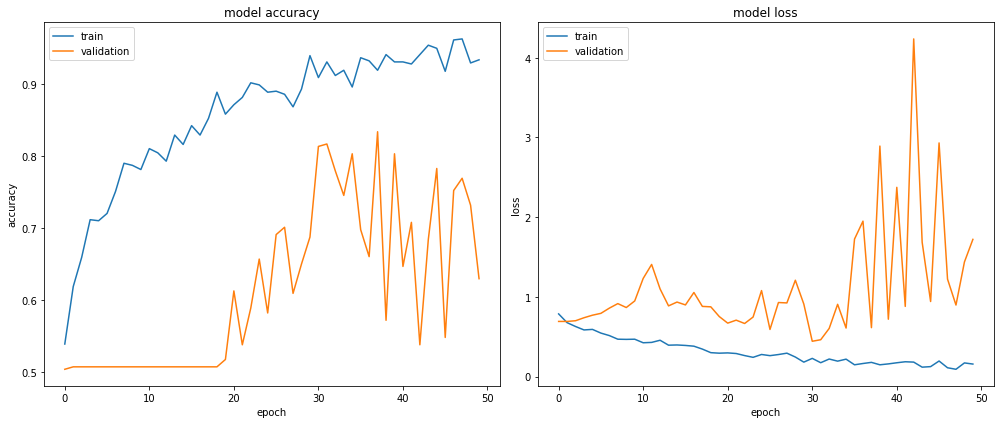

In [11]:
def plot_hist(hist):
    fig,axes = plt.subplots(1,2,figsize=(14,6))

    plt.subplot(axes[0])
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    
    plt.subplot(axes[1])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")

    plt.tight_layout()
    plt.show()


plot_hist(hist)

## Part 3: Make Prediction

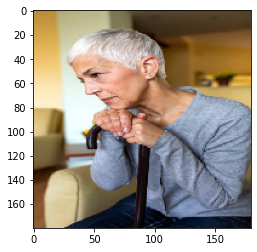

This image is 4.09 percent dementia and 95.91 percent normal.


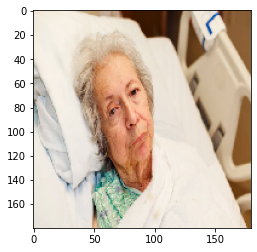

This image is 3.12 percent dementia and 96.88 percent normal.


In [14]:
# Test data from dementia class
test1 = ['1194374633','1197743455']
for i in test1:
  img = keras.preprocessing.image.load_img("/content/drive/My Drive/STAT8021/project/dementia_data/test/dementia/istockphoto-"+i+"-612x612.jpg", target_size=image_size)
  plt.imshow(img)
  plt.show()

  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  score = predictions[0]
  print(
      "This image is %.2f percent dementia and %.2f percent normal."
      % (100 * (1 - score), 100 * score)
  )

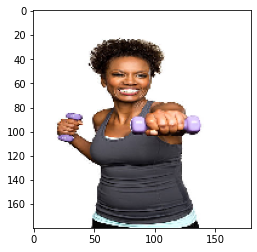

This image is 0.00 percent dementia and 100.00 percent normal.


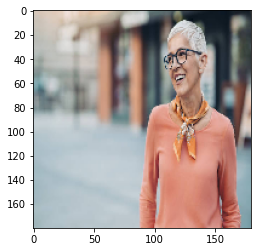

This image is 0.00 percent dementia and 100.00 percent normal.


In [15]:
# Test data from normal class
test2 = ['185290931','1214385230']
for i in test2:
  img = keras.preprocessing.image.load_img("/content/drive/My Drive/STAT8021/project/dementia_data/test/normal/istockphoto-"+i+"-612x612.jpg", target_size=image_size)
  plt.imshow(img)
  plt.show()

  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  score = predictions[0]
  print(
      "This image is %.2f percent dementia and %.2f percent normal."
      % (100 * (1 - score), 100 * score)
  )